In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *
import scipy.io

In [2]:
root_3dhp = '/home/hrai/Datasets/HAAI/3DHP'
source = 'original' # 
root_original = os.path.join(root_3dhp, source)
train_folder = os.path.join(root_original, 'train')
test_folder = os.path.join(root_original, 'test')

In [3]:
# Test video info
video_info = {'train': {}, 'test': {}}

for subject in os.listdir(test_folder):
    if 'TS' not in subject:
        continue
    video_info['test'][subject] = {}
    num_frame = len(os.listdir(f'/home/hrai/Datasets/HAAI/3DHP/original/test/{subject}/imageSequence'))
    img_list = natsorted(glob(f'/home/hrai/Datasets/HAAI/3DHP/original/test/{subject}/imageSequence/*.jpg'))
    img = cv2.imread(img_list[0])
    H, W, C = img.shape
    video_info['test'][subject]['num_frame'] = num_frame
    video_info['test'][subject]['W'] = W
    video_info['test'][subject]['H'] = H
video_info['test']

{'TS2': {'num_frame': 6080, 'W': 2048, 'H': 2048},
 'TS5': {'num_frame': 320, 'W': 1920, 'H': 1080},
 'TS4': {'num_frame': 6009, 'W': 2048, 'H': 2048},
 'TS1': {'num_frame': 6151, 'W': 2048, 'H': 2048},
 'TS3': {'num_frame': 5839, 'W': 2048, 'H': 2048},
 'TS6': {'num_frame': 492, 'W': 1920, 'H': 1080}}

In [4]:
# Test camera parameters
cam_param = {
    'test_cam_1_4': {
        'origin': np.array([3427.28, 1387.86, 309.42]),
        'up': np.array([-0.208215, 0.976233, 0.06014]),
        'right': np.array([0.000575281, 0.0616098, -0.9981]),
        'sensor_size': 10, # in mm
        'focal_length': 7.32506, # in mm
        'pixel_aspect': 1.00044, # y / x
        'center_offset': np.array([-0.0322884, 0.0929296]) # in mm (positive values move right and down)
    },
    'test_cam_5_6': {
        'origin': np.array([-2104.3074, 1038.6707, -4596.6367]),
        'up': np.array([0.025272345, 0.995038509, 0.096227370]),
        'right': np.array([-0.939647257, -0.009210289, 0.342020929]),
        'sensor_size': 10, # in mm
        'focal_length': 8.770747185, # in mm
        'pixel_aspect': 0.993236423, # 
        'center_offset': np.array([-0.104908645, 0.104899704]) # in mm (positive values move right and down)
    }
}

for key in cam_param.keys():
    up = cam_param[key]['up']
    right = cam_param[key]['right']
    forward = np.cross(up, right)
    R = np.array([right, -up, forward])
    C = cam_param[key]['origin']/1000
    t = -R@C
    #extrinsic = np.hstack((R, t.reshape(-1, 1)))
    #print(extrinsic.shape)
    cam_param[key]['R'] = R
    cam_param[key]['t'] = t
    cam_param[key]['C'] = C
    #print(R, t, C)
    
# train camera parameters
f = open(os.path.join(train_folder, 'S1', 'Seq1', 'camera.calibration'), 'r')
lines = f.readlines()
name = -1

for line in lines:
    item = line.strip().split(' ')
    item_type = item[0]
    #print(item)
    if item_type == 'name':
        name = item[-1]
        cam_param[name] = {}
    elif item_type == 'intrinsic':
        fx = float(item[3])
        cx = float(item[5])
        fy = float(item[8])
        cy = float(item[9])
        intrinsic = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        cam_param[name]['intrinsic'] = intrinsic
    elif item_type == 'extrinsic':
        R = np.array([[float(item[3]), float(item[4]), float(item[5])], [float(item[7]), float(item[8]), float(item[9]),], [float(item[11]), float(item[12]), float(item[13])]])
        t = np.array([float(item[6]), float(item[10]), float(item[14])])
        C = -R.T@t
        #print(R.shape, t.shape)
        cam_param[name]['R'] = R
        cam_param[name]['t'] = t
        cam_param[name]['C'] = C

In [5]:
# get test data
data_dict = {}
for subject in natsorted(os.listdir(test_folder)):
    if 'TS' not in subject:
        continue
    print(subject)
    data_dict[subject] = {}
    data = scipy.io.loadmat(f'/home/hrai/Datasets/HAAI/3DHP/original/test/{subject}/annot_data.mat')
    #for key in data.keys():
    #    print(key, type(data[key]), np.array(data[key]).shape)

    data_dict[subject]['annot2'] = mpi_inf_3dhp2h36m(np.transpose(data['annot2'][:, :, 0, :], (2, 1, 0))).copy()
    data_dict[subject]['annot3'] = mpi_inf_3dhp2h36m(np.transpose(data['annot3'][:, :, 0, :], (2, 1, 0))).copy()
    data_dict[subject]['visible_frame'] = data['visible_frame'][0].copy()
    print(data_dict[subject]['annot2'].shape, data_dict[subject]['annot3'].shape, data_dict[subject]['visible_frame'].shape)
    #break

TS1
(6151, 17, 2) (6151, 17, 3) (6151,)
TS2
(6080, 17, 2) (6080, 17, 3) (6080,)
TS3
(5838, 17, 2) (5838, 17, 3) (5838,)
TS4
(6007, 17, 2) (6007, 17, 3) (6007,)
TS5
(320, 17, 2) (320, 17, 3) (320,)
TS6
(492, 17, 2) (492, 17, 3) (492,)


In [6]:
# get train data
for subject in natsorted(os.listdir(train_folder)):
    for seq in natsorted(os.listdir(os.path.join(train_folder, subject))):
        #print(subject, seq)
        data = scipy.io.loadmat(os.path.join(train_folder, subject, seq, 'annot.mat'))
        #print(data.keys())
        
        for cam_num in range(14):
            source = '_'.join([subject, seq, f'cam{cam_num}'])
            data_dict[source] = {}
            anoot2 = mpi_inf_3dhp2h36m(np.array(data['annot2'][cam_num][0].reshape(-1, 28, 2)).copy())
            annot3 = mpi_inf_3dhp2h36m(np.array(data['annot3'][cam_num][0].reshape(-1, 28, 3)).copy())
            univ_annot3 = mpi_inf_3dhp2h36m(np.array(data['univ_annot3'][cam_num][0].copy().reshape(-1, 28, 3)).copy())
            # get valid frame
            w_over_range = (anoot2[:, :, 0] > 2048) | (anoot2[:, :, 0] < 0)
            h_over_range = (anoot2[:, :, 1] > 2048) | (anoot2[:, :, 1] < 0)
            over_range = np.logical_or(w_over_range, h_over_range)
            visible_frame = np.logical_not(np.any(over_range, axis=1))
            num_visible_frames = len(np.where(visible_frame == True)[0])
            print(f'{source} total_frame: {len(anoot2)} visible_frame: {num_visible_frames}')
            
            data_dict[source]['annot2'] = anoot2
            data_dict[source]['annot3'] = annot3
            data_dict[source]['univ_annot3'] = univ_annot3
            data_dict[source]['visible_frame'] = visible_frame
            data_dict[source]['num_visible_frames'] = num_visible_frames
            #print(anoot2.shape, annot3.shape, univ_annot3.shape)
    #         break
    #     break
    # break


S1_Seq1_cam0 total_frame: 6416 valid_frame: 4797
S1_Seq1_cam1 total_frame: 6416 valid_frame: 6245
S1_Seq1_cam2 total_frame: 6416 valid_frame: 5015
S1_Seq1_cam3 total_frame: 6416 valid_frame: 5216
S1_Seq1_cam4 total_frame: 6416 valid_frame: 5532
S1_Seq1_cam5 total_frame: 6416 valid_frame: 5645
S1_Seq1_cam6 total_frame: 6416 valid_frame: 6184
S1_Seq1_cam7 total_frame: 6416 valid_frame: 5026
S1_Seq1_cam8 total_frame: 6416 valid_frame: 5175
S1_Seq1_cam9 total_frame: 6416 valid_frame: 5362
S1_Seq1_cam10 total_frame: 6416 valid_frame: 6266
S1_Seq1_cam11 total_frame: 6416 valid_frame: 5814
S1_Seq1_cam12 total_frame: 6416 valid_frame: 5530
S1_Seq1_cam13 total_frame: 6416 valid_frame: 4883
S1_Seq2_cam0 total_frame: 12430 valid_frame: 10865
S1_Seq2_cam1 total_frame: 12430 valid_frame: 11977
S1_Seq2_cam2 total_frame: 12430 valid_frame: 10830
S1_Seq2_cam3 total_frame: 12430 valid_frame: 10817
S1_Seq2_cam4 total_frame: 12430 valid_frame: 11266
S1_Seq2_cam5 total_frame: 12430 valid_frame: 12106
S1_S

In [7]:
# intrinsic   1500.172 0 1017.387 0 0 1500.837 1043.032 0 0 0 1 0 0 0 0 1 
# extrinsic   0.000575281 0.06160985 -0.9981001 221.3543 0.2082146 -0.9762325 -0.06013997 659.87 -0.978083 -0.2077844 -0.01338968 3644.688 0 0 0 1 
# ts1_intrinsic = np.array([[1500.172, 0, 1017.387], [0, 1500.837, 1043.032], [0, 0, 1]])
# ts1_R = np.array([[0.000575281, 0.06160985, -0.9981001], [0.2082146, -0.9762325, -0.06013997], [-0.978083, -0.2077844, -0.01338968]])
# ts1_t = np.array([221.3543, 659.87, 3644.688])/1000

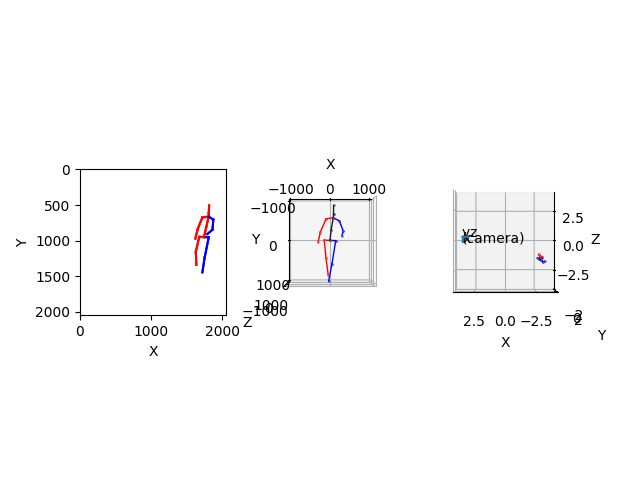

In [8]:
from matplotlib import axes


subject = 'TS1'
if subject in ['TS1', 'TS2', 'TS3', 'TS4']:
    R = cam_param['test_cam_1_4']['R']
    t = cam_param['test_cam_1_4']['t']
    C = cam_param['test_cam_1_4']['C']
    intrinsic = np.array([[1500.172, 0, 1017.387], [0, 1500.837, 1043.032], [0, 0, 1]])
elif subject in ['TS5', 'TS6']:
    R = cam_param['test_cam_5_6']['R']
    t = cam_param['test_cam_5_6']['t']
    C = cam_param['test_cam_5_6']['C']
    raise NotImplementedError('TS5 and TS6 not implemented')

camera = Camera(origin=C, 
                calib_mat=intrinsic, 
                cam_default_R=R, 
                IMAGE_HEIGHT=1000, 
                IMAGE_WIDTH=1000,
                cam_name='camera')

fx = intrinsic[0, 0]
fy = intrinsic[1, 1]
cx = intrinsic[0, 2]
cy = intrinsic[1, 2]

frame_num = 500
img_2d_gt = data_dict[subject]['annot2'][frame_num]
cam_3d = data_dict[subject]['annot3'][frame_num]
cam_3d_hat = get_rootrel_pose(cam_3d)
world_3d = (R.T @ (cam_3d - t).T).T/1000
#proj_2d = np.matmul(intrinsic, cam_3d.T).T
#proj_2d = proj_2d[:, :2] / proj_2d[:, 2:3]

box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

# 2.5d factor
pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용


H, W = video_info['test'][subject]['H'], video_info['test'][subject]['W']

fig = plt.figure(1)
fig.clear()
ax = axes_2d(fig, loc=131, H=H, W=W)
ax_cam = axes_3d(fig, loc=132, view=(-90,-90), xlim=(-1000, 1000), ylim=(-1000, 1000), zlim=(-1000, 1000))
ax_world = axes_3d(fig, loc=133, view=(0, 90), xlim=(-4, 4), zlim=(-4, 4))
draw_2d_pose(ax, img_2d, H=H, W=W)
draw_2d_pose(ax, img_2d_gt, H=H, W=W)  

#draw_3d_pose(ax_cam, cam_3d)
draw_3d_pose(ax_cam, cam_3d_hat)
draw_3d_pose(ax_cam, img_3d_hat*pred_lambda, color='r')

draw_3d_pose(ax_world, world_3d)
plt.sca(ax_world)
camera.cam_frame.draw3d()
plt.show()

In [21]:
R

array([[ 5.75281000e-04,  6.16098000e-02, -9.98100000e-01],
       [ 2.08215000e-01, -9.76233000e-01, -6.01400000e-02],
       [-9.78083371e-01, -2.07784794e-01, -1.33896928e-02]])

In [16]:
cam_3d.shape, t.shape, (cam_3d - t).shape

((17, 3), (3,), (17, 3))

### Find the corresponding keypoint between oringal and posynda 3dhp keypoints


In [143]:
posynda_train_data = np.load('/home/hrai/Datasets/HAAI/3DHP/posynda/data_train_3dhp_ori.npz', allow_pickle=True)['data'].item()

for i, kp1 in enumerate(posynda_train_data['S1 Seq1'][0]['0']['data_2d'][frame_num]):
    x, y = kp1
    #print(i)
    for j, kp2 in enumerate(data_dict['S1_Seq1_cam0']['annot2'][frame_num]):
        x2, y2 = kp2
        if np.allclose([x, y], [x2, y2], atol=1e-2):
            print(f'posynda kp {i} <- original kp {j}')
            break

posynda kp 0 <- original kp 7
posynda kp 1 <- original kp 5
posynda kp 2 <- original kp 14
posynda kp 3 <- original kp 15
posynda kp 4 <- original kp 16
posynda kp 5 <- original kp 9
posynda kp 6 <- original kp 10
posynda kp 7 <- original kp 11
posynda kp 8 <- original kp 23
posynda kp 9 <- original kp 24
posynda kp 10 <- original kp 25
posynda kp 11 <- original kp 18
posynda kp 12 <- original kp 19
posynda kp 13 <- original kp 20
posynda kp 14 <- original kp 4
posynda kp 15 <- original kp 3
posynda kp 16 <- original kp 6


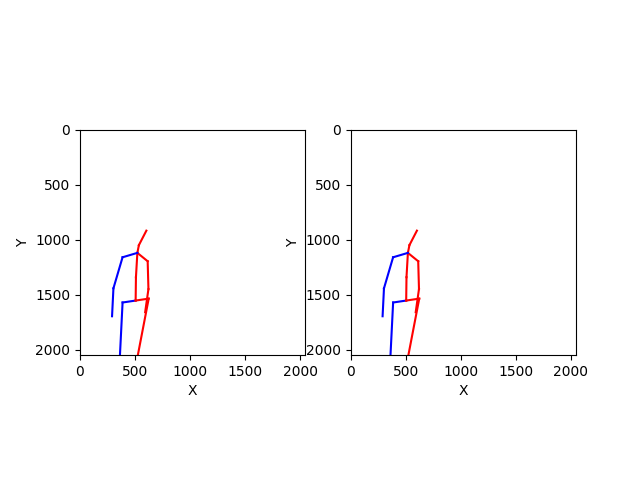

In [155]:
frame_num = 500
posynda_2d = mpi_inf_3dhp2h36m(train_data['S1 Seq1'][0]['0']['data_2d'])[frame_num]
original_2d = mpi_inf_3dhp2h36m(data_dict['S1_Seq1_cam0']['annot2'])[frame_num]
fig = plt.figure(2)
fig.clear()
ax = axes_2d(fig, loc=121, H=H, W=W)
as2 = axes_2d(fig, loc=122, H=H, W=W)
draw_2d_pose(ax, posynda_2d, H=H, W=W)
draw_2d_pose(as2, original_2d, H=H, W=W)
plt.show()

### Calculate scale factor (train)

[[1142.16624077]]


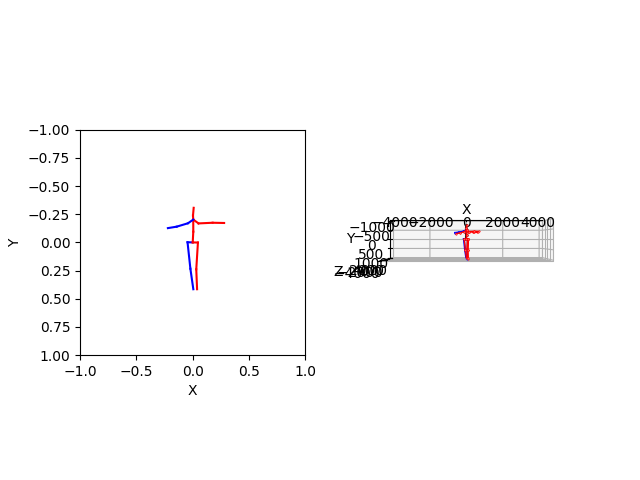

In [34]:
source = 'S1_Seq1_cam5'
subject, seq, cam_num = source.split('_')
cam_num = cam_num[-1]

R = cam_param[str(cam_num)]['R']
t = cam_param[str(cam_num)]['t']
C = cam_param[str(cam_num)]['C']
intrinsic = cam_param[str(cam_num)]['intrinsic']

fx = intrinsic[0, 0]
fy = intrinsic[1, 1]
cx = intrinsic[0, 2]
cy = intrinsic[1, 2]

frame_num = 0
valid_visible_frameframe = data_dict[source]['visible_frame']
num_visible_frames = data_dict[source]['num_visible_frames']
img_2d_gt = data_dict[source]['annot2'][visible_frame][frame_num]
# canonical
# img_2d_gt -= img_2d_gt[0]
# scale = np.linalg.norm(img_2d_gt.reshape(1, -1), ord=2, axis=1, keepdims=True) # (17, 1)
# print(scale)
# img_2d_gt /= scale

cam_3d = data_dict[source]['annot3'][visible_frame][frame_num]
cam_3d_hat = get_rootrel_pose(cam_3d)
#world_3d = (R.T@cam_3d.T).T - C
#proj_2d = np.matmul(intrinsic, cam_3d.T).T
#proj_2d = proj_2d[:, :2] / proj_2d[:, 2:3]

box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

# 2.5d factor
pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용

H, W = 2048, 2048
fig = plt.figure(3)
fig.clear()
ax = axes_2d(fig, loc=121, H=H, W=W, normalize=True)
ax_cam = axes_3d(fig, loc=122, view=(-90,-90), xlim=(-4000, 4000), ylim=(-1000, 1000), zlim=(-4000, 4000))
#ax_world = axes_3d(fig, loc=133)
#draw_2d_pose(ax, img_2d, H=H, W=W)
draw_2d_pose(ax, img_2d_gt, H=H, W=W)
#draw_3d_pose(ax_cam, cam_3d)
#draw_3d_pose(ax_world, world_3d)

draw_3d_pose(ax_cam, cam_3d)
draw_3d_pose(ax_cam, cam_3d_hat)
draw_3d_pose(ax_cam, img_3d_hat*pred_lambda, color='r')
plt.show()

### Generate video

In [35]:
stride = 5
fps = 25/stride

overwrite = True
normalized_scale = True
for cam_num in [0, 1, 2, 4, 5, 6, 7, 8]:
    for input_centering in [True, False]:
        source = f'S1_Seq1_cam{cam_num}'
        #input_centering = True
        visible_frame = data_dict[source]['visible_frame']
        end_frame = data_dict[source]['num_visible_frames']
        video_path = f'/home/hrai/codes/MotionBERT/custom_codes/dataset_generation/3dhp/3dhp_origianl_{source}_annot2_h36m_keypoint'
        if len(visible_frame) > 0: video_path += '_only_visible_frame'
        if input_centering: video_path += '_input_centering'
        if normalized_scale: video_path += '_norm_scale'
        video_path += '.mp4'
        print(video_path)
        if os.path.exists(video_path) and not overwrite: 
            print('video already exists')
        else:
            videowriter = imageio.get_writer(video_path, fps=fps)

            fig = plt.figure(4)
            fig.clear()
            fig.suptitle(source)
            ax = axes_2d(fig, H=H, W=W, normalize=True)
            for frame_num in tqdm(range(0, end_frame, stride)):
                clear_axes(ax)
                img_2d_gt = data_dict[source]['annot2'][visible_frame][frame_num]
                if input_centering: 
                    img_2d_gt -= img_2d_gt[0]
                    #img_2d_gt += np.array([W//2, H//2])
                if normalized_scale:
                    scale = np.linalg.norm(img_2d_gt.reshape(1, -1), ord=2, axis=1, keepdims=True) # (17, 1)
                    img_2d_gt /= scale
                draw_2d_pose(ax, img_2d_gt, H=H, W=W, normalize=True)
                
                canvas = FigureCanvas(fig)
                canvas.draw()
                image_from_plot = np.array(canvas.renderer._renderer)
                image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)
                videowriter.append_data(image_from_plot)
            videowriter.close()
        #break
    #break

/home/hrai/codes/MotionBERT/custom_codes/dataset_analysis/3dhp/3dhp_origianl_S1_Seq1_cam0_annot2_h36m_keypoint_only_visible_frame_input_centering_norm_scale.mp4


100%|██████████| 960/960 [00:19<00:00, 48.20it/s]


### Generate test pkl

In [10]:
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_test_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


for subject in os.listdir(test_folder):
    if 'TS' not in subject:
        continue
    file_name = subject + '.pkl'
    save_path = os.path.join(save_folder, file_name)
    # if os.path.exists(save_path):
    #     print(f'{file_name} already exists')
    #     continue

    data = {}
    for key in ['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']:
        data[key] = []
        
    if subject in ['TS1', 'TS2', 'TS3', 'TS4']:
        R = cam_param['test_cam_1_4']['R']
        t = cam_param['test_cam_1_4']['t']
        C = cam_param['test_cam_1_4']['C']
        intrinsic = np.array([[1500.172, 0, 1017.387], [0, 1500.837, 1043.032], [0, 0, 1]])
    elif subject in ['TS5', 'TS6']:
        R = cam_param['test_cam_5_6']['R']
        t = cam_param['test_cam_5_6']['t']
        C = cam_param['test_cam_5_6']['C']
        #raise NotImplementedError('TS5 and TS6 not implemented')
        print('TS5 and TS6 not implemented')
        continue
    
    extrinsic = np.hstack((R, t.reshape(-1, 1)))
    cam_param_ = {'R': R, 't': t, 'C': C, 'intrinsic': intrinsic, 'extrinsic': extrinsic} 
    
    source = subject
    action = subject
    camera_id = subject

    fx = intrinsic[0, 0]
    fy = intrinsic[1, 1]
    cx = intrinsic[0, 2]
    cy = intrinsic[1, 2]

    for frame_num in tqdm(range(len(data_dict[subject]['annot2']))):
        cam_3d = data_dict[subject]['annot3'][frame_num]
        cam_3d_hat = get_rootrel_pose(cam_3d)
        world_3d = (R.T @ (cam_3d - t).T).T/1000

        box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
        img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
        img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

        # 2.5d factor
        pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용
        
        # joint 2.5d image
        img_25d = img_3d * pred_lambda

        # store
        data['joint_2d'].append(np.array(img_2d).copy()) 
        data['confidence'].append(np.ones(17)) 
        data['joint3d_image'].append(np.array(img_3d).copy()) 
        data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
        data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
        data['camera_name'].append(np.array(camera_id).copy()) 
        data['action'].append(np.array(action).copy()) 
        data['source'].append(np.array(source).copy()) 
        data['frame'].append(np.array(frame_num).copy()) 
        data['cam_3d'].append(np.array(cam_3d).copy()) 
        data['world_3d'].append(np.array(world_3d).copy())
        data['cam_param'].append(np.array(cam_param_).copy())

    
    savepkl(data, save_path)
    #break

100%|██████████| 6080/6080 [00:15<00:00, 381.06it/s]


TS5 and TS6 not implemented


100%|██████████| 5838/5838 [00:19<00:00, 301.24it/s]


TS5 and TS6 not implemented


### train pkl

In [247]:
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_train_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
pass_cam = [] # [0, 1, 2, 4, 5, 6, 7, 8]


for subject in natsorted(os.listdir(train_folder)):
    for seq in natsorted(os.listdir(os.path.join(train_folder, subject))):
        for cam_num in range(14):
            if len(pass_cam) > 0:
                if cam_num not in pass_cam: continue
            source = '_'.join([subject, seq, f'cam{cam_num}'])
            file_name = source + '.pkl'
            save_path = os.path.join(save_folder, file_name)
            if os.path.exists(save_path):
                print(f'{file_name} already exists')
                continue
            
            data = {}
            for key in ['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']:
                data[key] = []
                
            R = cam_param[str(cam_num)]['R']
            t = cam_param[str(cam_num)]['t']
            C = cam_param[str(cam_num)]['C']
            intrinsic = cam_param[str(cam_num)]['intrinsic']
            
            action = source
            camera_id = cam_num
            
            fx = intrinsic[0, 0]
            fy = intrinsic[1, 1]
            cx = intrinsic[0, 2]
            cy = intrinsic[1, 2]
            
            visible_frame = data_dict[source]['visible_frame']
            num_visible_frames = data_dict[source]['num_visible_frames']
            
            pbar = tqdm(range(num_visible_frames))
                        
            for frame_num in pbar:
                cam_3d = data_dict[source]['annot3'][visible_frame][frame_num]
                cam_3d_hat = get_rootrel_pose(cam_3d)

                box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
                img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
                img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

                # 2.5d factor
                pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용
                
                # joint 2.5d image
                img_25d = img_3d * pred_lambda

                # store
                data['joint_2d'].append(np.array(img_2d).copy()) 
                data['confidence'].append(np.ones(17)) 
                data['joint3d_image'].append(np.array(img_3d).copy()) 
                data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
                data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
                data['camera_name'].append(np.array(camera_id).copy()) 
                data['action'].append(np.array(action).copy()) 
                data['source'].append(np.array(source).copy()) 
                data['frame'].append(np.array(frame_num).copy()) 
                data['cam_3d'].append(np.array(cam_3d).copy()) 
                
                pbar.postfix = f'{source} frame: {frame_num}'

            savepkl(data, save_path)

S1_Seq1_cam0.pkl already exists
S1_Seq1_cam1.pkl already exists
S1_Seq1_cam2.pkl already exists
S1_Seq1_cam3.pkl already exists
S1_Seq1_cam4.pkl already exists
S1_Seq1_cam5.pkl already exists
S1_Seq1_cam6.pkl already exists
S1_Seq1_cam7.pkl already exists
S1_Seq1_cam8.pkl already exists
S1_Seq1_cam9.pkl already exists
S1_Seq1_cam10.pkl already exists
S1_Seq1_cam11.pkl already exists
S1_Seq1_cam12.pkl already exists
S1_Seq1_cam13.pkl already exists
S1_Seq2_cam0.pkl already exists
S1_Seq2_cam1.pkl already exists
S1_Seq2_cam2.pkl already exists
S1_Seq2_cam3.pkl already exists
S1_Seq2_cam4.pkl already exists
S1_Seq2_cam5.pkl already exists
S1_Seq2_cam6.pkl already exists
S1_Seq2_cam7.pkl already exists
S1_Seq2_cam8.pkl already exists
S1_Seq2_cam9.pkl already exists
S1_Seq2_cam10.pkl already exists
S1_Seq2_cam11.pkl already exists
S1_Seq2_cam12.pkl already exists
S1_Seq2_cam13.pkl already exists
S2_Seq1_cam0.pkl already exists
S2_Seq1_cam1.pkl already exists
S2_Seq1_cam2.pkl already exists


  4%|▍         | 541/12124 [00:02<00:52, 218.72it/s, S3_Seq2_cam11 frame: 540]


KeyboardInterrupt: 